In [37]:
import cellxgene_census
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from datetime import timedelta

import requests
import concurrent.futures

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [38]:
census = cellxgene_census.open_soma(census_version="2024-04-01") # current "latest" is "2024-04-01"
info = census['census_info']['summary'].read().concat().to_pandas()
info

,soma_joinid,label,value
0,0,census_schema_version,2.0.0
1,1,census_build_date,2024-04-01
2,2,dataset_schema_version,5.0.0
3,3,total_cell_count,114405937
4,4,unique_cell_count,59761180
5,5,number_donors_homo_sapiens,17082
6,6,number_donors_mus_musculus,4186


In [39]:
mus = (
    census["census_data"]['mus_musculus']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

homo = (
    census["census_data"]['homo_sapiens']
    .obs.read(
        value_filter="is_primary_data==True",
        column_names=['dataset_id', 'nnz']
    )
    .concat()
    .to_pandas()
)

In [40]:
mus['dataset_id'] = mus['dataset_id'].cat.remove_unused_categories()
homo['dataset_id'] = homo['dataset_id'].cat.remove_unused_categories()

mus_sums = mus.groupby('dataset_id').sum()
homo_sums = homo.groupby('dataset_id').sum()

mus_sums = mus_sums.rename(columns={'nnz': 'dataset_total_nnz_count', 'is_primary_data': 'dataset_total_primary_cell_count'})
homo_sums = homo_sums.rename(columns={'nnz': 'dataset_total_nnz_count', 'is_primary_data': 'dataset_total_primary_cell_count'})

all_sums = pd.concat((mus_sums, homo_sums))

/var/folders/tg/n7kwvm_x1kgdj1k46pvny2dw0000gn/T/ipykernel_25732/2530534421.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mus_sums = mus.groupby('dataset_id').sum()
/var/folders/tg/n7kwvm_x1kgdj1k46pvny2dw0000gn/T/ipykernel_25732/2530534421.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  homo_sums = homo.groupby('dataset_id').sum()


In [41]:
ds_meta = census['census_info']['datasets'].read().concat().to_pandas()

ds_meta_mus = ds_meta.merge(mus_sums, left_on='dataset_id', right_index=True)
ds_meta_homo = ds_meta.merge(homo_sums, left_on='dataset_id', right_index=True)
ds_meta = ds_meta.merge(all_sums, left_on='dataset_id', right_index=True)

In [42]:
def get_publication_date(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        pub_date = data['message'].get('created', {}).get('date-time')
        return pub_date
    else:
        return np.nan

with concurrent.futures.ThreadPoolExecutor() as executor:
    pub_dates = list(executor.map(get_publication_date, ds_meta['collection_doi'].unique()))

pub_dates = dict(zip(ds_meta['collection_doi'].unique(), pub_dates))

In [43]:
def process_dataset_meta(ds_meta, pub_dates):
    # Map publication dates
    ds_meta['pub_date'] = ds_meta['collection_doi'].map(pub_dates)
    ds_meta['pub_date'] = pd.to_datetime(ds_meta['pub_date'])

    # Remove missing publication dates
    ds_meta = ds_meta.dropna(subset=['pub_date'])

    # Group, sum, and reset index
    ds_meta = ds_meta.groupby(['collection_name', 'collection_id', 'collection_doi', 'pub_date'])[['dataset_total_primary_cell_count', 'dataset_total_nnz_count']].sum().reset_index()
    ds_meta = ds_meta.rename(columns={'dataset_total_primary_cell_count': 'collection_total_primary_cell_count', 'dataset_total_nnz_count': 'collection_total_nnz_count'})

    # Order by publication date
    ds_meta = ds_meta.sort_values(by='pub_date')

    # Calculate cumulative cell counts
    ds_meta['cum_cell_counts'] = ds_meta['collection_total_primary_cell_count'].cumsum()

    # Calculate cumulative non-zero counts
    ds_meta['cum_nnz'] = ds_meta['collection_total_nnz_count'].cumsum()

    return ds_meta


In [44]:
ds_meta = process_dataset_meta(ds_meta, pub_dates)
ds_meta_mus = process_dataset_meta(ds_meta_mus, pub_dates)
ds_meta_homo = process_dataset_meta(ds_meta_homo, pub_dates)

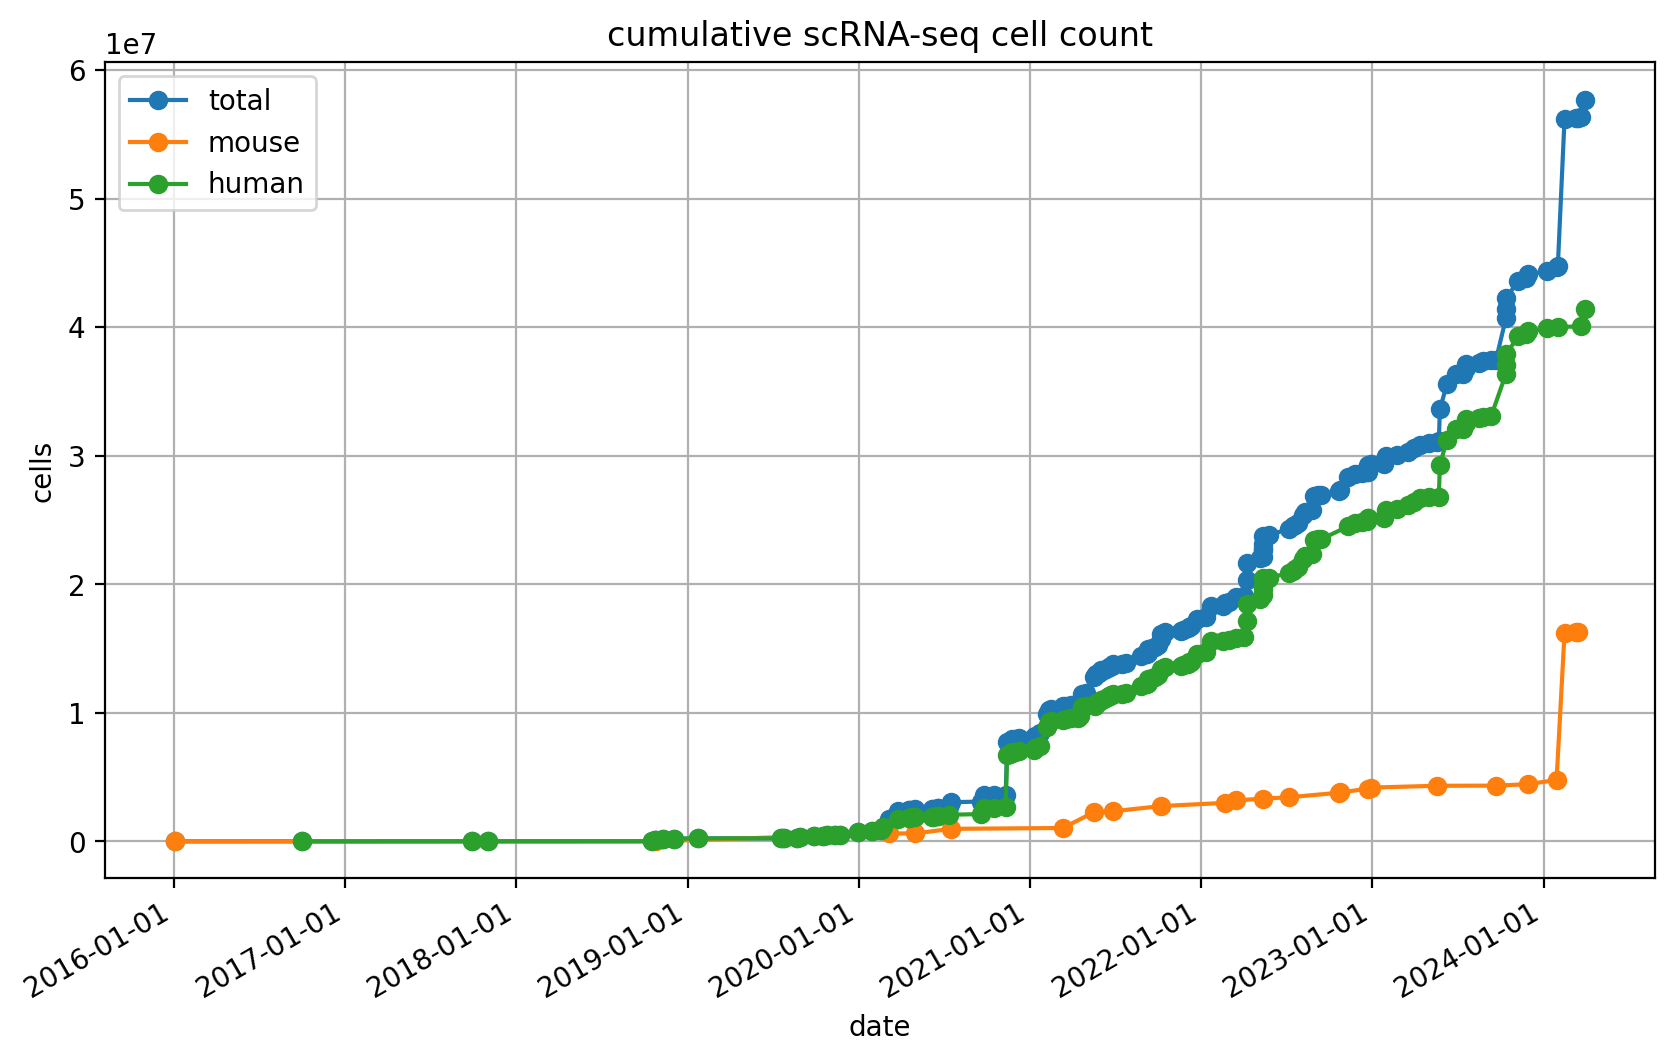

In [45]:
dataset_stats = {'total': ds_meta, 'mouse': ds_meta_mus, 'human': ds_meta_homo}

# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_cell_counts'], marker='o', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('date')
plt.ylabel('cells')
plt.title('cumulative scRNA-seq cell count')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

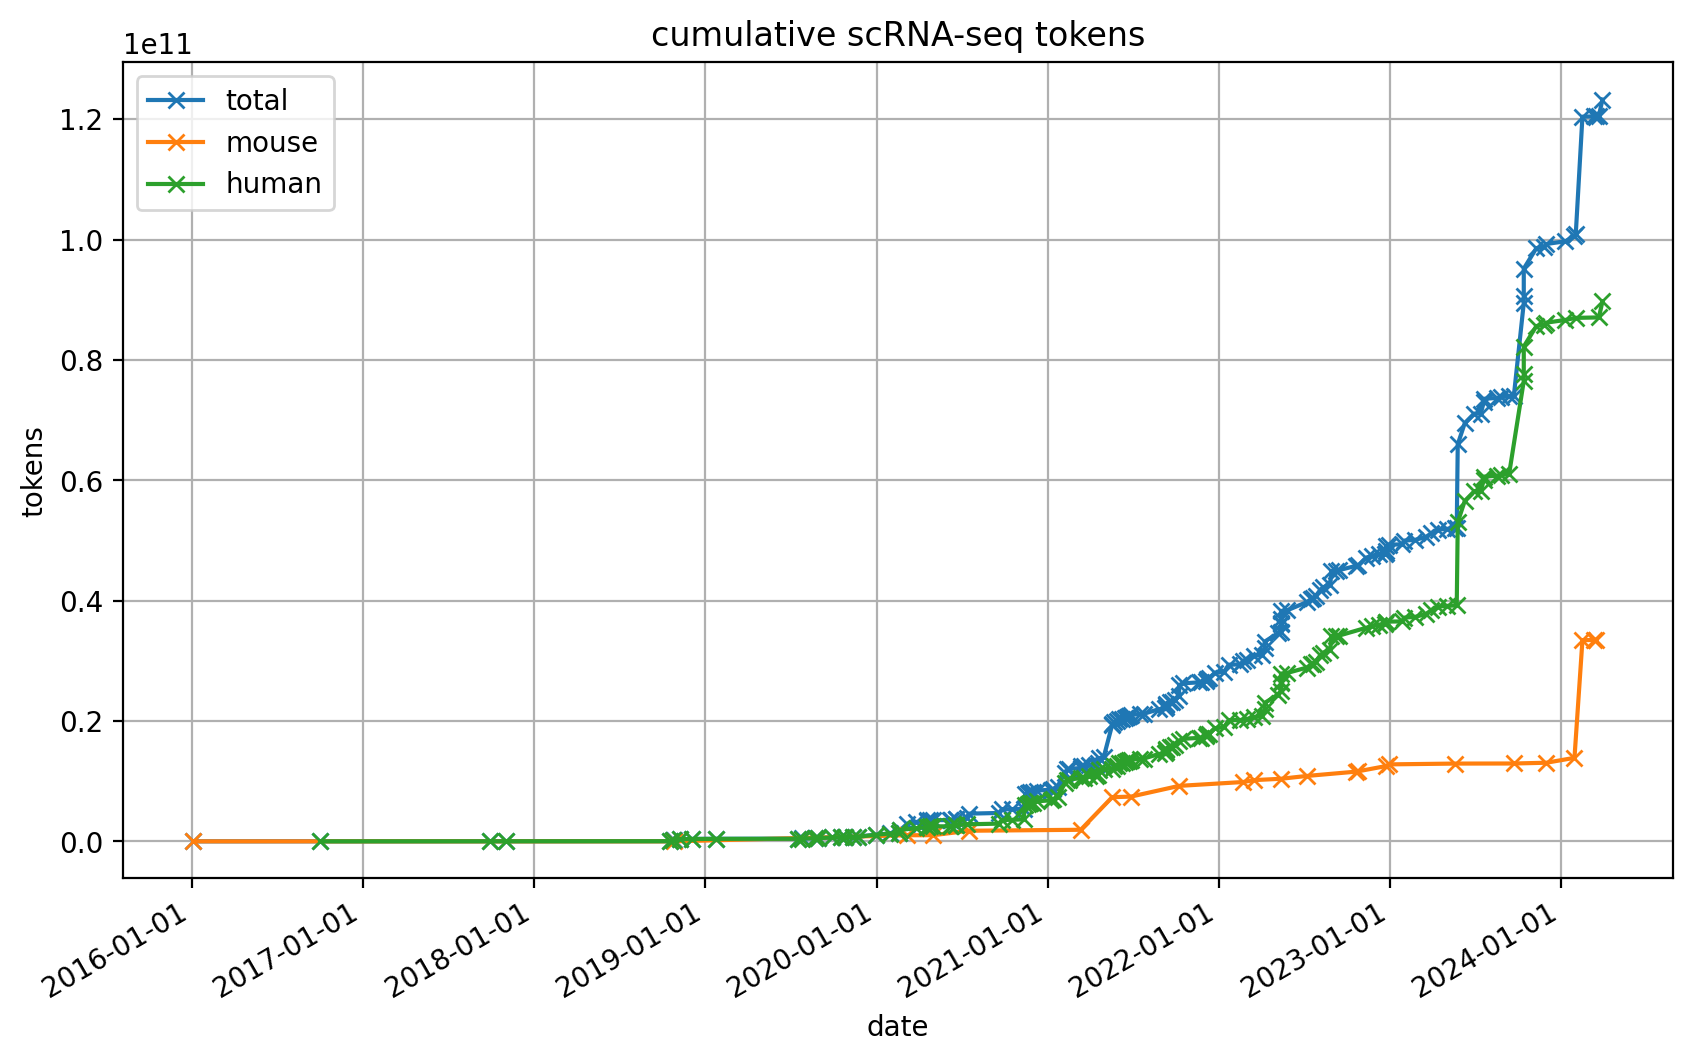

In [46]:
# Plotting
plt.figure(figsize=(10, 6))

for title,df in dataset_stats.items():
    plt.plot(df['pub_date'], df['cum_nnz'], marker='x', label=title)

# Formatting the date axis
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

plt.legend()
plt.xlabel('date')
plt.ylabel('tokens')
plt.title('cumulative scRNA-seq tokens')
plt.grid(True)
plt.gcf().autofmt_xdate()  # Auto-format for better date label appearance
plt.show()

In [47]:
print(f"Total number of tokens: {ds_meta['cum_nnz'].max():.3E}")

Total number of tokens: 1.233E+11


Tokens for 50M cells: 9.599E+10


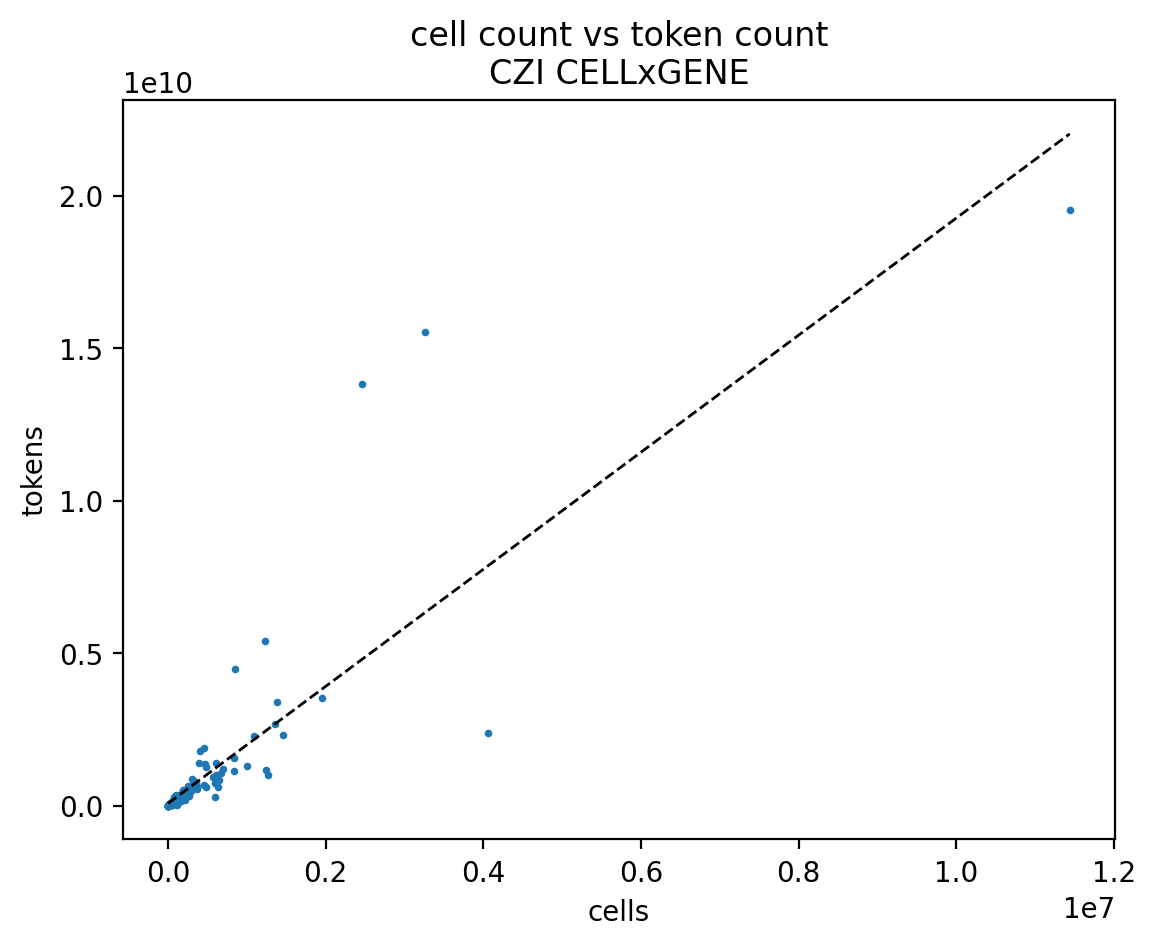

In [48]:
# Prepare data for the linear model
X = ds_meta['collection_total_primary_cell_count'].to_numpy().reshape(-1,1)
y = ds_meta['collection_total_nnz_count'].to_numpy()

# Fit the linear model
linear_model = LinearRegression()
linear_model.fit(X, y)

X_pred = np.arange(X.min(), X.max(), 10**4).reshape(-1,1)
y_pred = linear_model.predict(X_pred)

# Plot
plt.scatter(X, y, s=3)
plt.plot(X_pred, y_pred, color='black', linestyle='dashed', linewidth=1)

# Calculate # tokens for 50M cells
scfound_cells = 5e7
d_scfound = linear_model.predict([[scfound_cells]])[0]
print(f"Tokens for 50M cells: {d_scfound:.3E}")

plt.xlabel('cells')
plt.ylabel('tokens')
plt.title('cell count vs token count\nCZI CELLxGENE')
plt.show()

### Forecast

/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/Users/willconnell/miniconda3/envs/scaling-bio/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


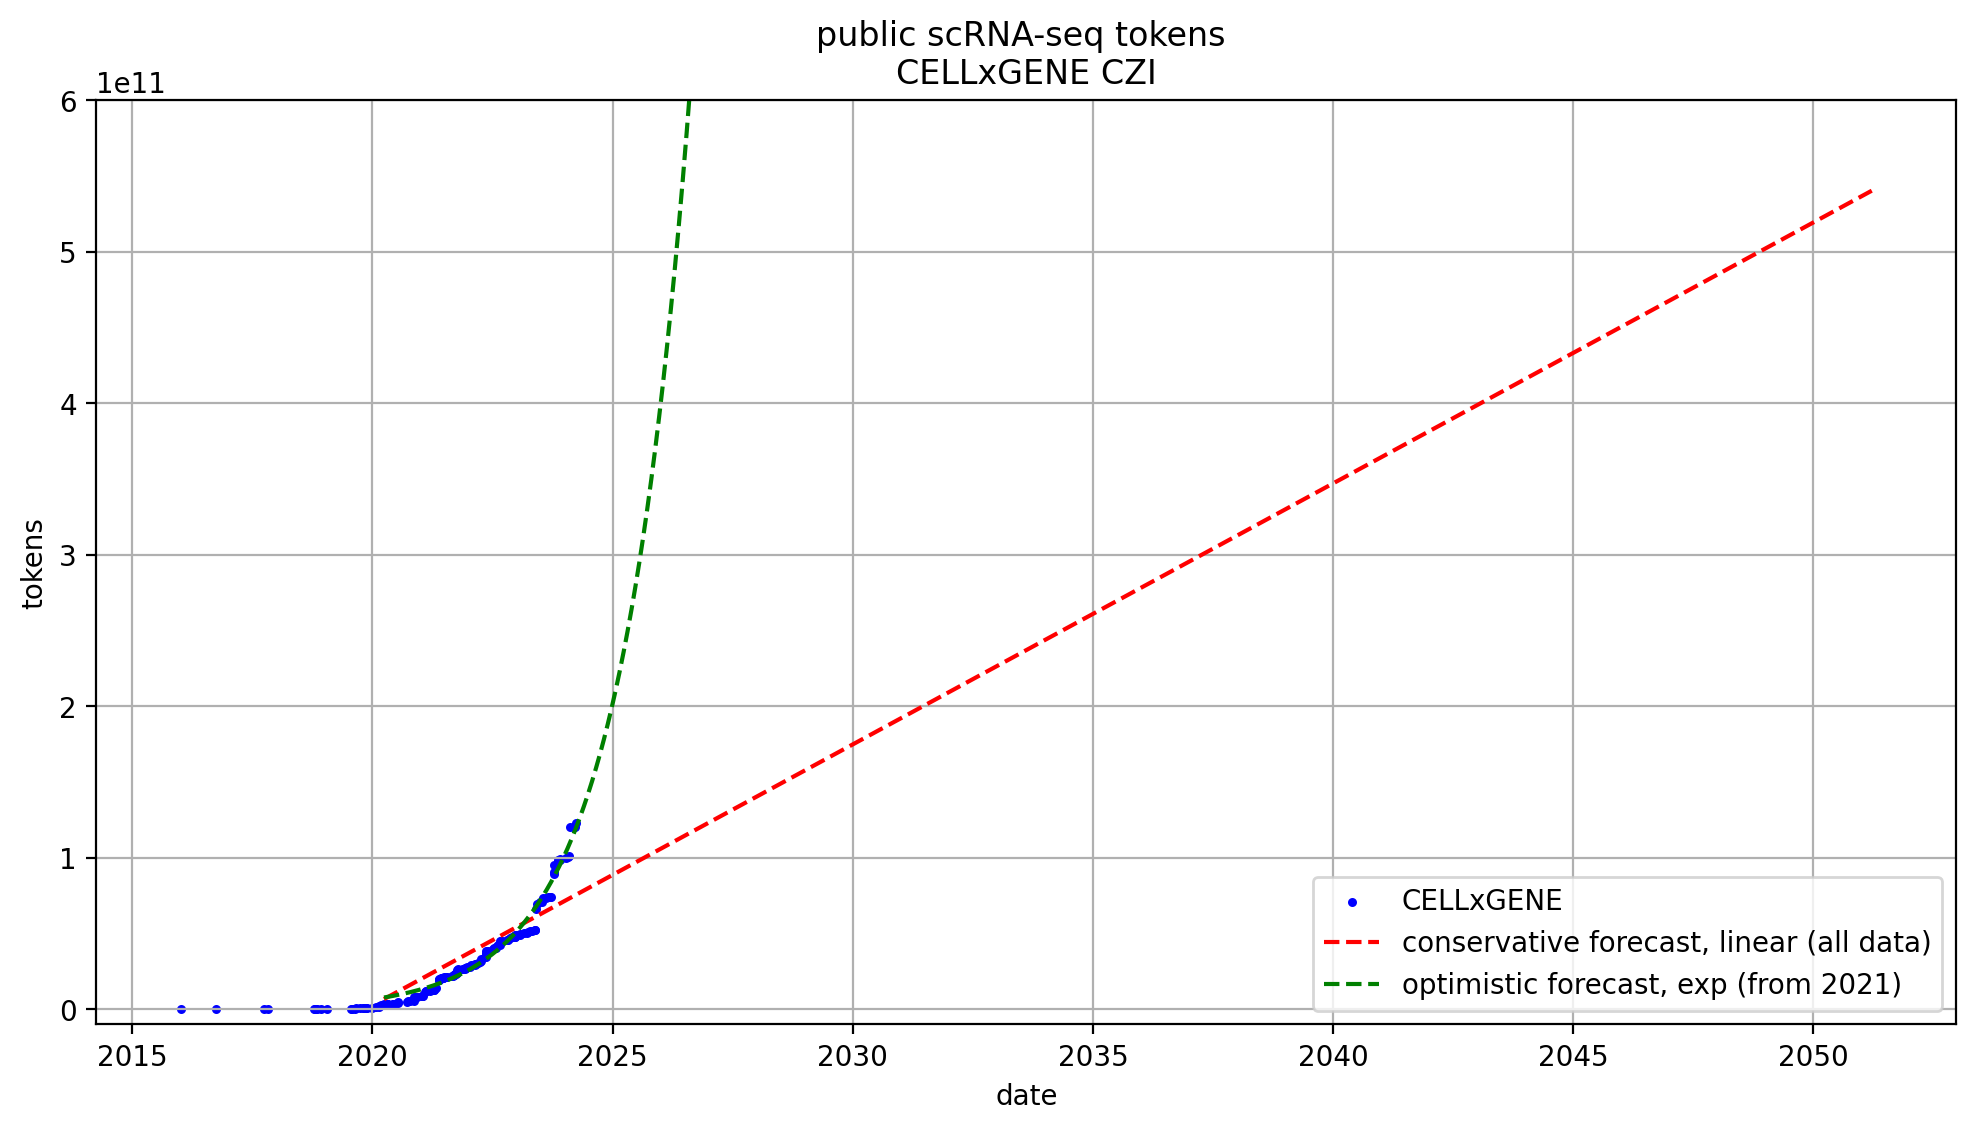

In [49]:
def fit_and_plot_models(ds_meta):
    # Ensure 'pub_date' is timezone-naive
    ds_meta['pub_date'] = ds_meta['pub_date'].dt.tz_localize(None)

    # Convert 'pub_date' to numeric (days since the earliest date)
    min_date = ds_meta['pub_date'].min()
    ds_meta['pub_date_numeric'] = (ds_meta['pub_date'] - min_date).dt.days

    # Prepare data for the linear model
    X = ds_meta[['pub_date_numeric']]
    y = ds_meta['cum_nnz']

    # Fit the linear model
    linear_model = LinearRegression()
    linear_model.fit(X, y)

    # Predict ~25 years for the linear model
    max_date_numeric = ds_meta['pub_date_numeric'].max() - (4 * 365) # start ~2021
    future_dates_all = pd.Series(range(max_date_numeric, max_date_numeric + 31 * 365))
    future_linear_predictions = linear_model.predict(future_dates_all.to_frame())

    # Fit an exponential model using data from 2021 onwards
    start_2021 = (pd.Timestamp('2021-01-01') - min_date).days
    X_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021][['pub_date_numeric']]
    y_2021 = ds_meta[ds_meta['pub_date_numeric'] >= start_2021]['cum_nnz']

    # Transform y_2021 for the exponential model
    y_2021_log = np.log(y_2021)

    exponential_model = LinearRegression()
    exponential_model.fit(X_2021, y_2021_log)

    # Predict for the exponential model and transform back
    future_exponential_predictions_log = exponential_model.predict(future_dates_all.to_frame())
    future_exponential_predictions = np.exp(future_exponential_predictions_log)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.scatter(ds_meta['pub_date'], y, color='blue', label='CELLxGENE', s=5)
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_linear_predictions, color='red', label='conservative forecast, linear (all data)', linestyle='dashed')
    plt.plot([min_date + timedelta(days=int(d)) for d in future_dates_all], future_exponential_predictions, color='green', label='optimistic forecast, exp (from 2021)', linestyle='dashed')

    # Set x-axis to display every 5 years
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(5))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.ylim((-1e10, 6e11))
    plt.xlabel('date')
    plt.ylabel('tokens')
    plt.title('public scRNA-seq tokens \nCELLxGENE CZI')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
fit_and_plot_models(ds_meta)


### Chinchilla compute-optimal model for current datasets

In [100]:
def chincilla_sl(n, d):
    return (406.4 / n ** 0.34) + (410.7 / d ** 0.28) + 1.69

n_range = np.logspace(6, 12, 7)
d_range = np.linspace(1e7, 1e13, int(1e6))

losses = []
for n in n_range:
    losses.append([chincilla_sl(n, d) for d in d_range])

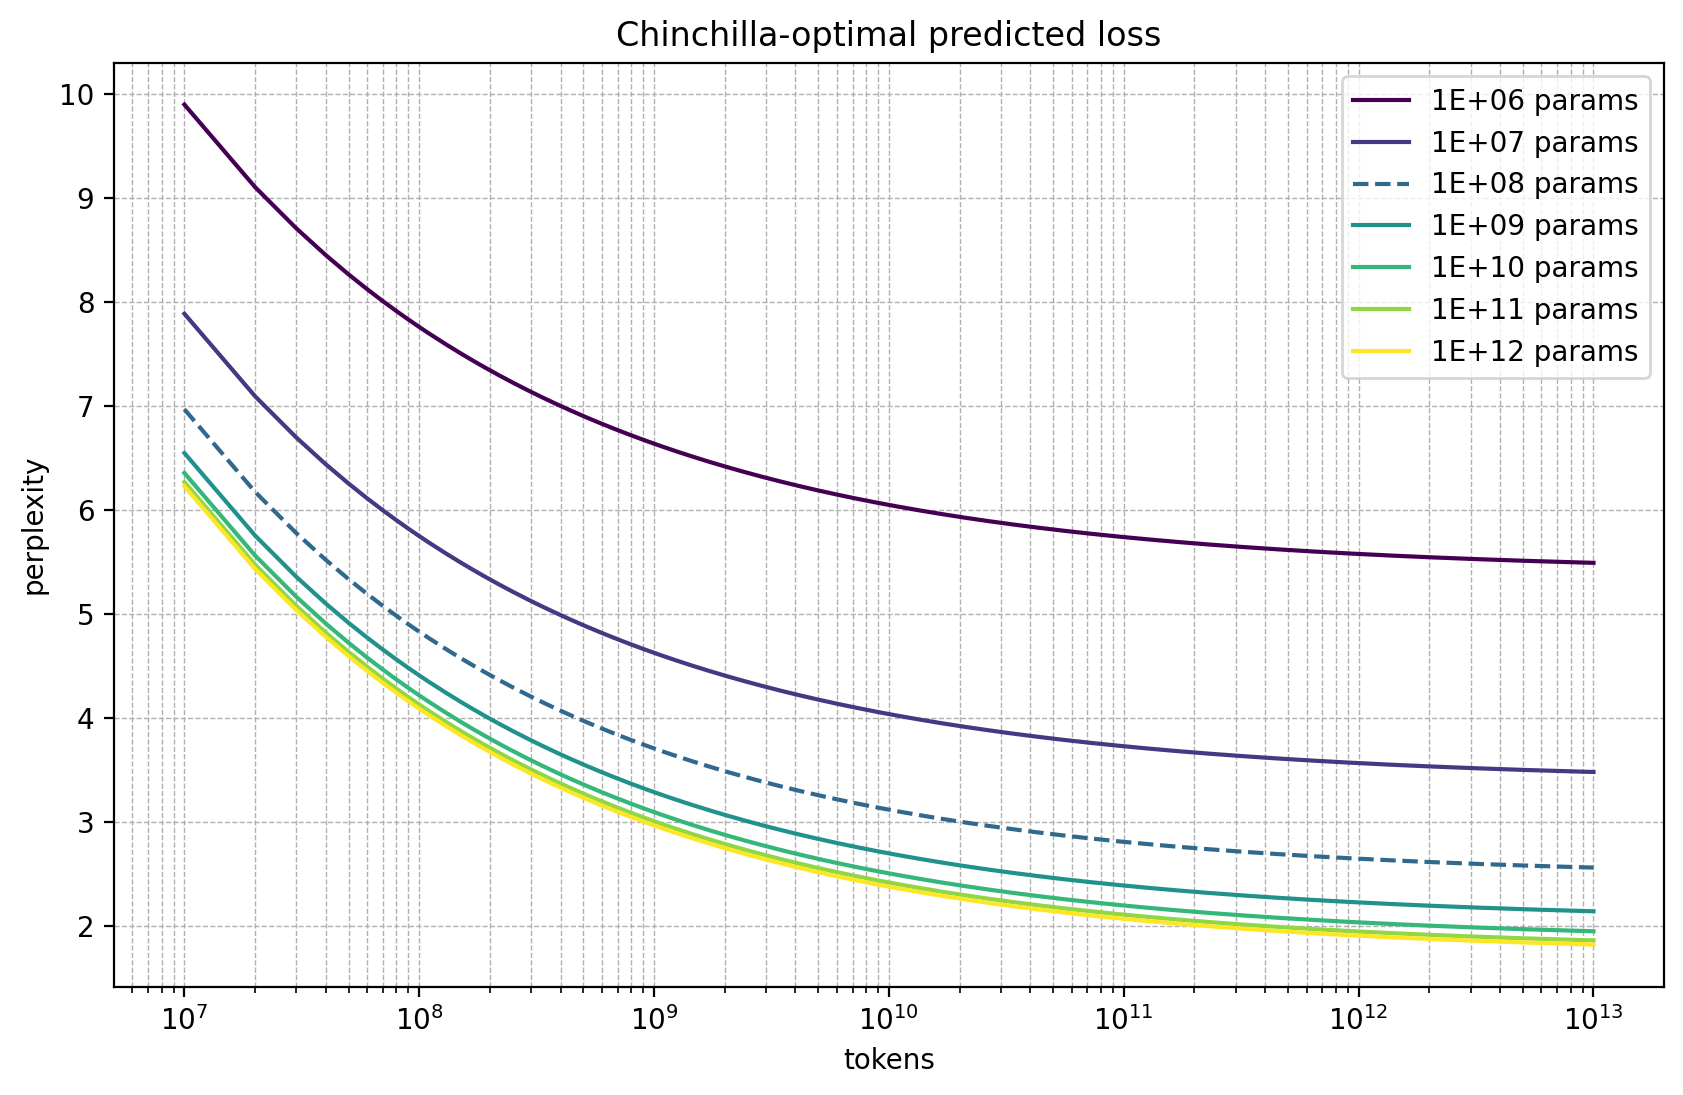

In [101]:
import matplotlib.cm as cm

plt.figure(figsize=(10, 6))
# plt.plot(n_range, losses_cellxgene, label='1T tokens')
# plt.plot(n_range, losses_scfound, label='96B tokens (scFoundation)')
colors = cm.viridis(np.linspace(0, 1, len(losses)))

for l, c, n in zip(losses, colors, n_range):
    ls = 'dashed'  if n == 1e8 else 'solid'
    plt.plot(d_range, l, label=f'{n:.0E} params', color=c, linestyle=ls)
plt.xscale('log')  # Set x-axis to logarithmic scale
plt.xlabel('tokens')
plt.ylabel('perplexity')
plt.title('Chinchilla-optimal predicted loss')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()